In [1]:
import pyemu
import os
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import pandas as pd
import matplotlib.pyplot as plt
import psutil
import shutil
import numpy as np
import sys

In [2]:
sys.path.insert(1, 'D:/spark/spark_gits/apexmf')

In [3]:
from apexmf import apexmf_pst_viz

In [4]:
# wd = "D:/spark/dolores_amrs"
wd = "d:/spark/Dolores"
os.chdir(wd)

In [5]:
t_d = os.path.join(wd, "dolores_amrs")

In [6]:
# test run
pyemu.os_utils.run("pestpp-ies dolores_amrs.pst",cwd=t_d)

# Prior

In [ ]:
pst.pestpp_options['ies_num_reals'] = 100
pst.control_data.noptmax = -1
pst.write(os.path.join(t_d,"dolores_amrs_rw_prior.pst"))

In [6]:
num_workers = psutil.cpu_count(logical=False)

In [7]:
m_d = "main_diagonal_pp_rw_prior_mc" 
pyemu.os_utils.start_workers(t_d,"pestpp-ies","dolores_amrs_rw_prior.pst",
                            num_workers=num_workers,
                            worker_root='.',
                            master_dir=m_d)

In [8]:
pst = pyemu.Pst(os.path.join(m_d, 'dolores_amrs_rw_prior.pst'))

In [9]:
obs_df = pd.read_csv(os.path.join(m_d,"dolores_amrs_rw_prior.0.obs.csv"),index_col=0)

In [11]:
obs = pst.observation_data.copy()
obs

,obsnme,obsval,weight,obgnme,oname,otype,usecol,time,i,j,totim
obsnme,,,,,,,,,,,
m038_cca_199201,m038_cca_199201,110.0,18.23460,m038_cca,NaN,NaN,NaN,NaN,NaN,NaN,NaN
m038_cca_199203,m038_cca_199203,140.0,18.23460,m038_cca,NaN,NaN,NaN,NaN,NaN,NaN,NaN
m038_cca_199204,m038_cca_199204,47.0,18.23460,m038_cca,NaN,NaN,NaN,NaN,NaN,NaN,NaN
m038_cca_199205,m038_cca_199205,47.0,18.23460,m038_cca,NaN,NaN,NaN,NaN,NaN,NaN,NaN
m038_cca_199206,m038_cca_199206,52.0,18.23460,m038_cca,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
m051_cso4_201101,m051_cso4_201101,60.3,8.56005,m051_cso4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
m051_cso4_201103,m051_cso4_201103,77.8,8.56005,m051_cso4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
m051_cso4_201106,m051_cso4_201106,56.0,8.56005,m051_cso4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
pr_oe = pyemu.ObservationEnsemble.from_csv(
    pst=pst,filename=os.path.join(m_d,"dolores_amrs_rw_prior.0.obs.csv")
    )
# pt_oe = pyemu.ObservationEnsemble.from_csv(pst=pst,filename=os.path.join(m_d,"animas_amrs_pp_pre_rw_prior.{0}.obs.csv".format(pst.control_data.noptmax)))


<Figure size 800x1050 with 0 Axes>

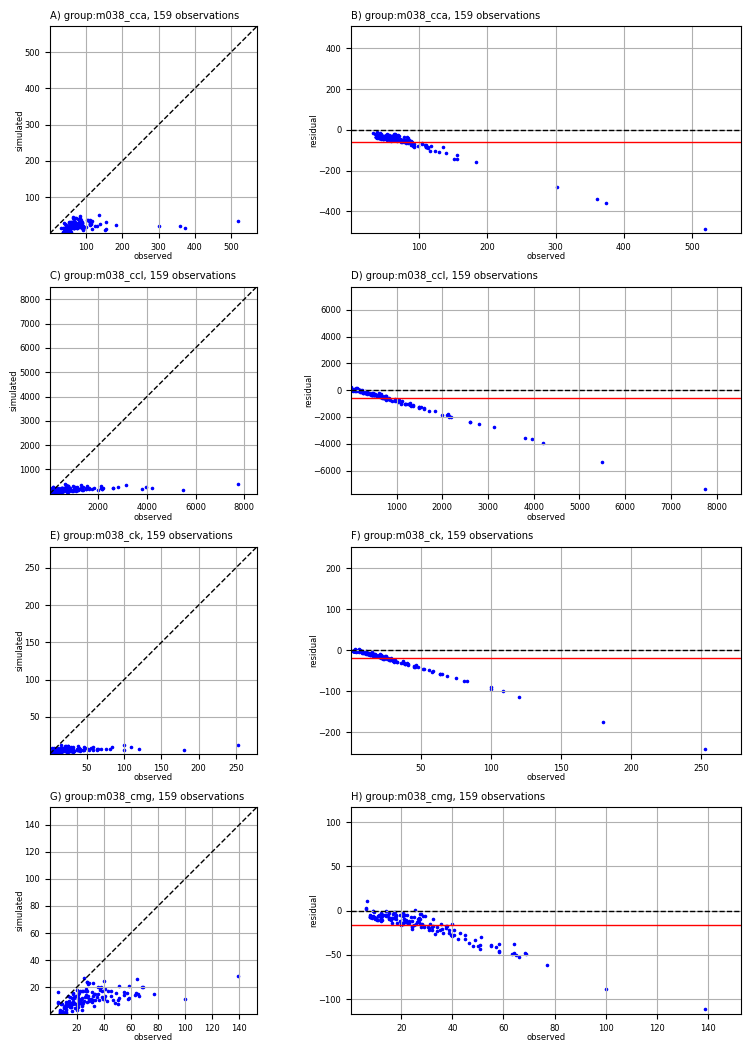

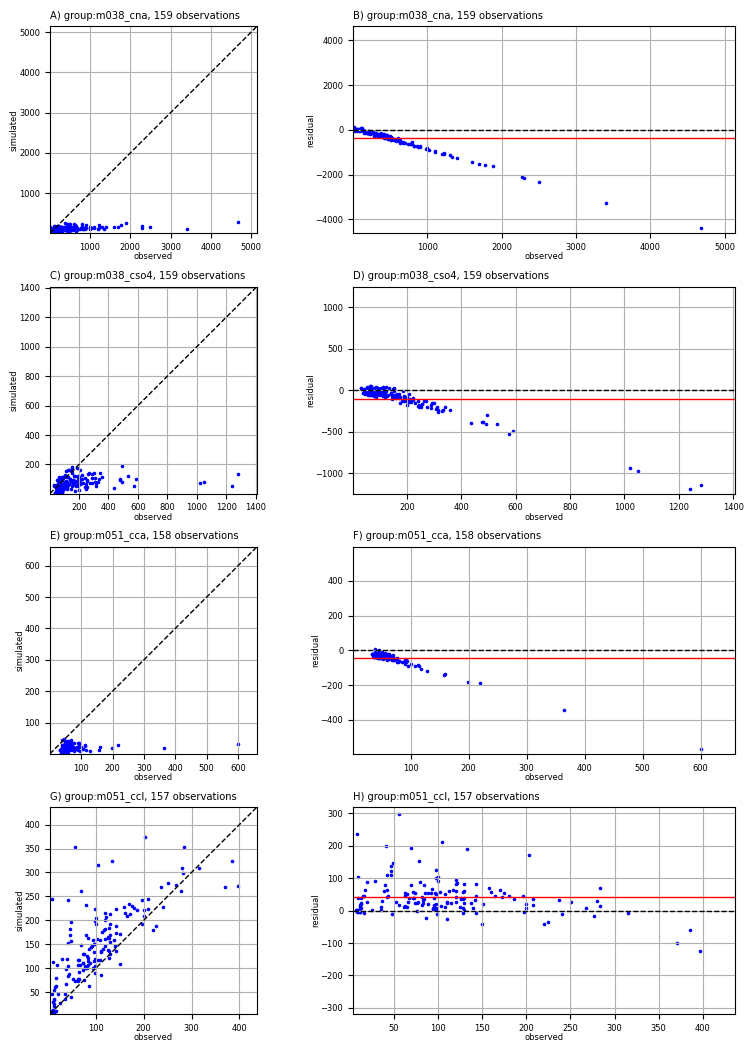

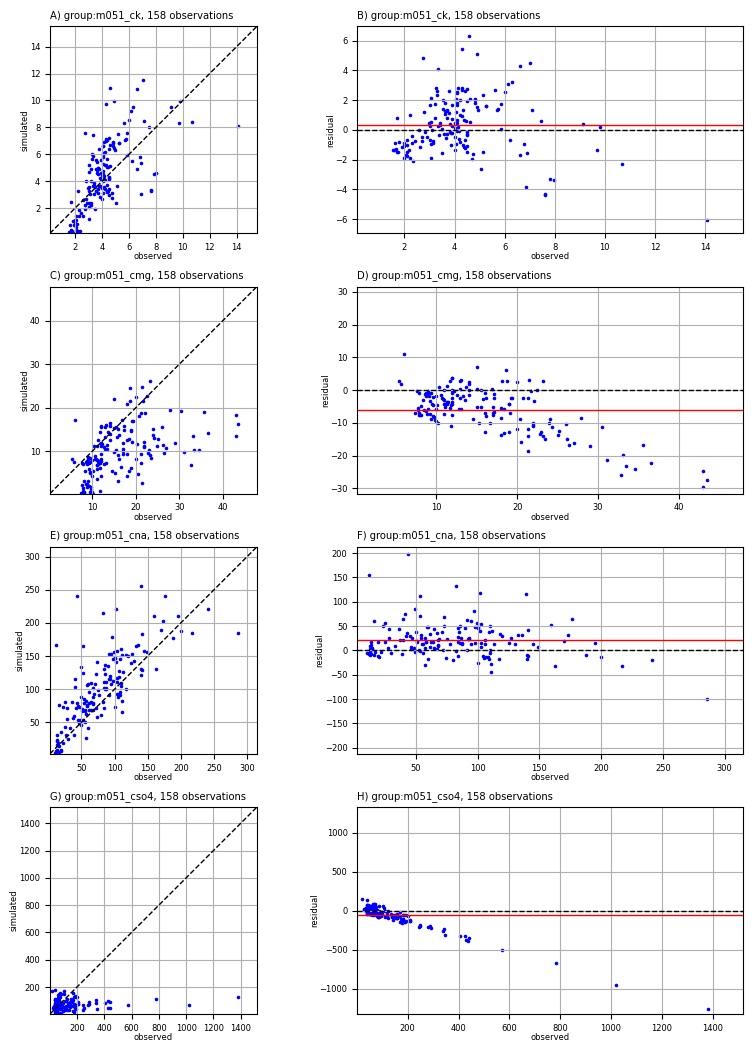

In [13]:
pyemu.plot_utils.res_1to1(pst);

In [14]:
def plot_tseries_prior_ensembles(pr_oe, dot=True):
    pst.try_parse_name_metadata()
    # get the observation data from the control file and select 
    obs = pst.observation_data.copy()
    obs = obs.loc[obs.obgnme.apply(lambda x: x in pst.nnz_obs_groups),:]
    # --- time control ---
    time_col = []
    for i in range(len(obs)):
        if obs.iloc[i, 0][0] == "g":
            time_col.append(obs.iloc[i, 0][-8:])
        else:
            time_col.append(obs.iloc[i, 0][-6:])
    obs['time'] = time_col
    # ---------------------
    ogs = obs.obgnme.unique()
    fig,axes = plt.subplots(len(ogs),1,figsize=(10,4*len(ogs)))
    ogs.sort()
    # for each observation group (i.e. timeseries)
    for ax,og in zip(axes,ogs):
        # get values for x axis
        oobs = obs.loc[obs.obgnme==og,:].copy()
        oobs.loc[:,"time"] = oobs.time.astype(str)
#         oobs.sort_values(by="time",inplace=True)
        tvals = oobs.time.values
        onames = oobs.obsnme.values
        if dot is True:
            # plot prior
            [ax.scatter(tvals,pr_oe.loc[i,onames].values,color="gray",s=30, alpha=0.2) for i in pr_oe.index]
            # plot posterior
#             [ax.scatter(tvals,pt_oe.loc[i,onames].values,color='b',s=30,alpha=0.2) for i in pt_oe.index]
            # plot measured+noise 
            oobs = oobs.loc[oobs.weight>0,:]
            tvals = oobs.time.values
            onames = oobs.obsnme.values
    #         [ax.plot(tvals,noise.loc[i,onames].values,"r",lw=0.5,alpha=0.5) for i in noise.index]
            ax.scatter(oobs.time,oobs.obsval,color='red',s=30).set_facecolor("none")
        if dot is False:
            # plot prior
            [ax.plot(tvals,pr_oe.loc[i,onames].values,"0.5",lw=0.5,alpha=0.5) for i in pr_oe.index]
            # plot posterior
#             [ax.plot(tvals,pt_oe.loc[i,onames].values,"b",lw=0.5,alpha=0.5) for i in pt_oe.index]
            # plot measured+noise 
            oobs = oobs.loc[oobs.weight>0,:]
            tvals = oobs.time.values
            onames = oobs.obsnme.values
    #         [ax.plot(tvals,noise.loc[i,onames].values,"r",lw=0.5,alpha=0.5) for i in noise.index]
            ax.plot(oobs.time,oobs.obsval,"r-",lw=2)
        ax.tick_params(axis='x', labelrotation=90)
        ax.margins(x=0.01)
        ax.set_title(og,loc="left")
    fig.tight_layout()
    return fig    

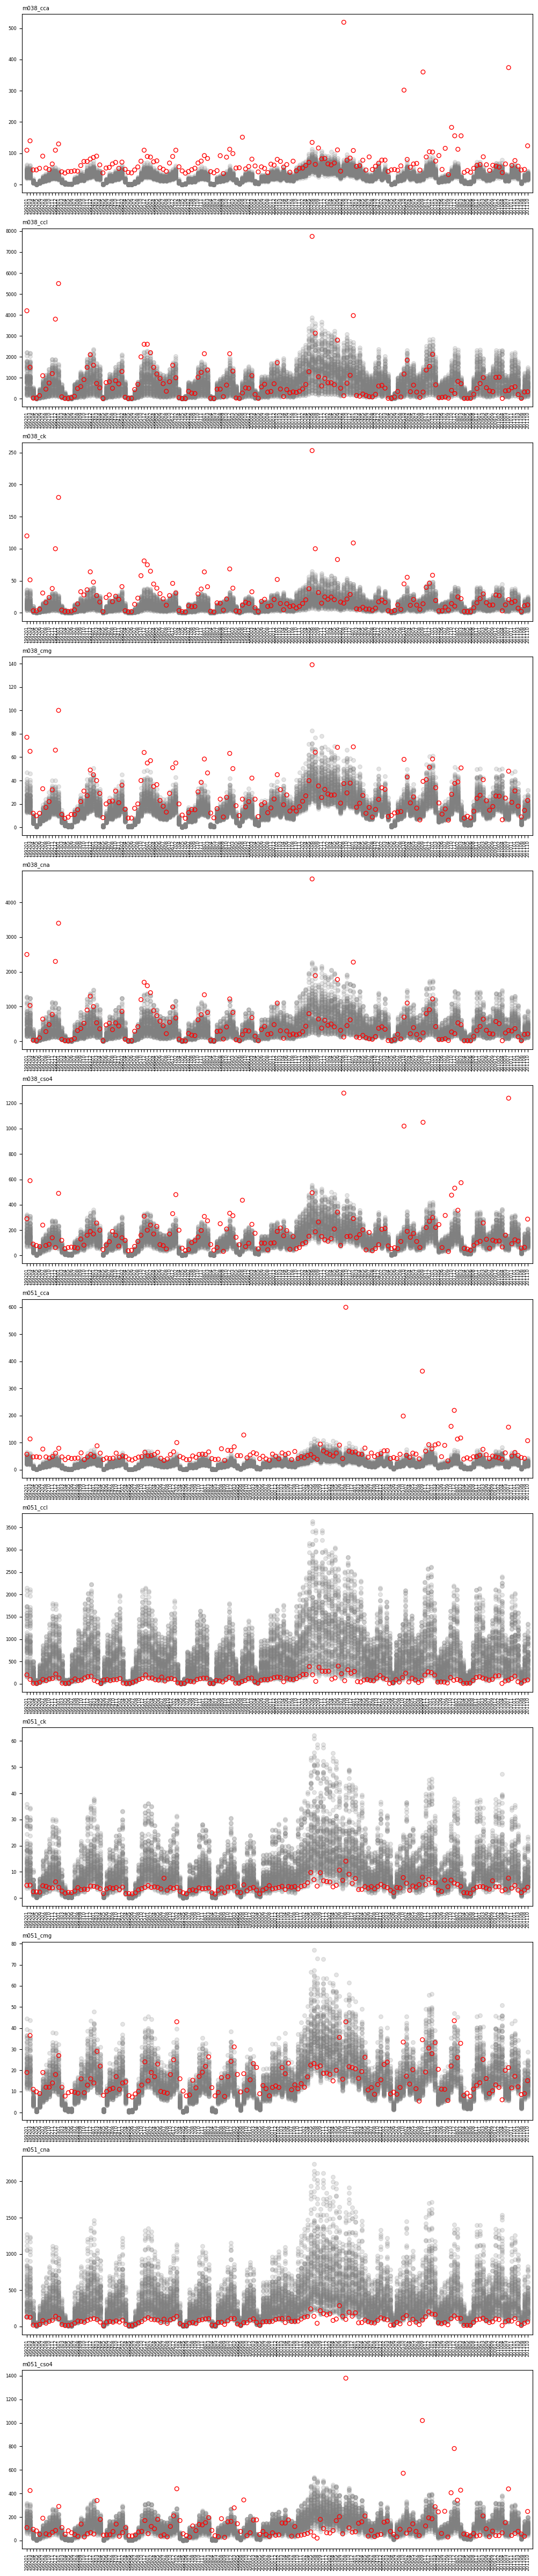

In [15]:
fig = plot_tseries_prior_ensembles(pr_oe, dot=True)

In [6]:
pst_path = os.path.join(template_ws, 'dolores_amrs.pst')

In [7]:
# pst_path = os.path.join(t_d, 'freyberg_mf6.pst')
pst = pyemu.Pst(pst_path)

In [9]:
par = pst.parameter_data

In [10]:
par

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,...,pstyle,i,j,x,y,zone,usecol,idx0,idx1,idx2
parnme,,,,,,,,,,,,,,,,,,,,,
salt_ca000,salt_ca000,log,factor,1.103870e+02,2.407010e+01,574.745000,salt_ca0,1.0,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
salt_ca001,salt_ca001,log,factor,1.103870e+02,2.407010e+01,574.745000,salt_ca0,1.0,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
salt_ca002,salt_ca002,log,factor,1.103870e+02,2.407010e+01,574.745000,salt_ca0,1.0,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
salt_ca003,salt_ca003,log,factor,1.103870e+02,2.407010e+01,574.745000,salt_ca0,1.0,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
salt_ca004,salt_ca004,log,factor,1.103870e+02,2.407010e+01,574.745000,salt_ca0,1.0,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
salt_hco3025,salt_hco3025,fixed,factor,1.000000e-07,1.000000e-08,0.000001,salt_hco30,1.0,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
salt_hco3026,salt_hco3026,fixed,factor,1.000000e-07,1.000000e-08,0.000001,salt_hco30,1.0,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
salt_hco3027,salt_hco3027,fixed,factor,1.000000e-07,1.000000e-08,0.000001,salt_hco30,1.0,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
os.getcwd()

'd:\\Projects\\Watersheds\\Dolores\\Analysis\\AMRSs\\apexmod_230124\\dr_121120\\dolores_amrs'

In [16]:
pyemu.os_utils.run('pestpp-glm dolores_amrs.pst', cwd=template_ws)

In [ ]:
pst.control_data.noptmax = -1

In [ ]:
pst.write(os.path.join(template_ws,"dolores_prior.pst"))

In [ ]:
pst.pestpp_options['ies_num_reals'] = 100
pst.control_data.noptmax = -1
pst.write(os.path.join(template_ws,"animas_diagprior2.pst"))

In [9]:
num_workers = psutil.cpu_count(logical=False)

In [8]:
m_d = "main_diagonal_prior_mc" 
pyemu.os_utils.start_workers(template_ws,"pestpp-ies","dolores_amrs_prior.pst",
                            num_workers=2,
                            worker_root='.',
                            master_dir=m_d)

C:\Users\seonggyu.park\AppData\Local\miniconda3\envs\apexmf\lib\site-packages\pyemu\utils\os_utils.py:143: PyemuWarning: unable to remove worker dir: .\worker_0
[WinError 5] Access is denied: '.\\worker_0\\pestpp-ies.exe'
C:\Users\seonggyu.park\AppData\Local\miniconda3\envs\apexmf\lib\site-packages\pyemu\utils\os_utils.py:143: PyemuWarning: unable to remove worker dir: .\worker_1
[WinError 5] Access is denied: '.\\worker_1\\pestpp-ies.exe'


Exception: start_workers() master returned non-zero: 3221226505

In [ ]:
pst = pyemu.Pst(os.path.join(template_ws, 'animas_diagprior.pst'))

In [ ]:
pst.write_par_summary_table(filename="none")

In [ ]:
pst.npar_adj

In [ ]:
obs_df = pd.read_csv(os.path.join(m_d,"animas_diagprior.0.obs.csv"),index_col=0)

In [ ]:
pst.try_parse_name_metadata()

In [ ]:
obs = pst.observation_data.copy()

In [ ]:
time_col = []
for i in range(len(obs)):
    if obs.iloc[i, 0][0] == "d":
        time_col.append(obs.iloc[i, 0][-8:])
    elif obs.iloc[i, 0][0] == "m":
        time_col.append(obs.iloc[i, 0][-6:])


In [ ]:
obs.time = time_col

In [ ]:
obs.loc[obs["obgnme"]=="m075_lso4"]

In [ ]:
ogs = obs.obgnme.unique()

In [ ]:
ogs

In [ ]:
ogs = [i for i in ogs if i[5] == "l"]

In [ ]:
fig,axes = plt.subplots(len(ogs),1,figsize=(10,5*len(ogs)))
ogs.sort()
for ax,og in zip(axes,ogs):
    oobs = obs.loc[obs.obgnme==og,:].copy()
    oobs.loc[:,"time"] = oobs.time.astype(str)
#     oobs.sort_values(by="time",inplace=True)
    tvals = oobs.time.values
    onames = oobs.obsnme.values
#     [ax.plot(tvals,obs_df.loc[i,onames].values,"0.5",lw=0.5,alpha=0.5) for i in obs_df.index]
    [ax.scatter(tvals,obs_df.loc[i,onames].values, color="gray", alpha=0.3) for i in obs_df.index]
    oobs = oobs.loc[oobs.weight>0,:]
    ax.scatter(oobs.time,oobs.obsval, color="red", label="Observed", s=30).set_facecolor("none")
    ax.tick_params(axis='x', labelrotation=45)
    ax.margins(x=0.01)
    ax.set_title(og,loc="left")